(section:attention)=
# Attention GCN
## Layer definition

We use the provided formula to define the Attention GCN layer; the only difference is that in order to obtain attention score for first-order neighbors, as suggested in the original paper, we 
multiply the attention score matrix by the adjacency matrix. 


In [1]:
import warnings
from sys import path
from os import environ

warnings.filterwarnings(
    "ignore"
)  # ignore warnings from missing deterministic implementation
environ[
    "WANDB_NOTEBOOK_NAME"
] = "AttentionGCN.ipynb"  # set notebook name for wandb
path.append("../code")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import model as m
import training as t
import utils
import logging
import sys
from utils import LOG as logger

logging.basicConfig(
    format="%(message)s", level=logging.INFO, stream=sys.stdout
)
logger.setLevel(logging.INFO)
# logger.setLevel(logging.DEBUG)

# t.WANDB_MODE = "disabled"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dataloaders, dataset = t.create_dataloaders(batch_size=20)

Length of train set: 131
Length of validation set: 28
Length of test set: 29


## Training

In [5]:
node_features = dataset.node_features.shape[2]
conv_dims = [256, 256, 128, 64, 32]
model = m.AttentionGCN(
    num_features=node_features,
    conv_dims=conv_dims,
    # fcn_layers=[128],
    activation=nn.LeakyReLU(),
    dropout=0.3,
    pooling="max",
    norm=nn.BatchNorm1d,
)

# utils._print_gradient_hook(model)


print(model)

Initialized model with 5 graph conv layers
Initialized model with 1 fully connected layers
AttentionGCN(
  (convs_layers): ModuleList(
    (0): AttentionConv(
      (weight): Linear(in_features=7, out_features=256, bias=False)
      (S): Linear(in_features=512, out_features=28, bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (att_activation): LeakyReLU(negative_slope=0.2)
      (softmax): Softmax(dim=2)
    )
    (1): AttentionConv(
      (weight): Linear(in_features=256, out_features=256, bias=False)
      (S): Linear(in_features=512, out_features=28, bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (att_activation): LeakyReLU(negative_slope=0.2)
      (softmax): Softmax(dim=2)
    )
    (2): AttentionConv(
      (weight): Linear(in_features=256, out_features=128, bias=False)
      (S): Linear(in_features=256, out_features=28, bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (att_activation): LeakyReLU(negative_slope=0.2)
  

In [6]:
learning_rate = 1e-4
epochs = 1500

model.to(DEVICE)

label_counts = dataset[:]["class_y"].unique(return_counts=True)[1]
pos_weight = label_counts[0] / label_counts[1]

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": 0,
    "loss": [],
    "acc": [],
    "val-roc": [],
    "val-ap": [],
}

In [7]:
history = t.train_loop(
    history=history,
    train_dataloader=dataloaders[0],
    val_dataloader=dataloaders[1],
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=DEVICE,
    use_scheduler=False,
    test_dataloader=dataloaders[2],
)

wandb: Currently logged in as: c-achard. Use `wandb login --relogin` to force relogin


Epoch   1/1500:Epoch loss: 0.4591 - avg acc: 30.5% - val-roc: 0.2577 - val-ap: 0.4456 (0.3s/epoch)
Epoch   2/1500:Epoch loss: 0.4697 - avg acc: 30.5% - val-roc: 0.2092 - val-ap: 0.4293 (0.2s/epoch)
Epoch   3/1500:Epoch loss: 0.4851 - avg acc: 30.5% - val-roc: 0.2245 - val-ap: 0.4424 (0.1s/epoch)
Epoch   4/1500:Epoch loss: 0.4719 - avg acc: 30.5% - val-roc: 0.2551 - val-ap: 0.4602 (0.1s/epoch)
Epoch   5/1500:Epoch loss: 0.4716 - avg acc: 30.5% - val-roc: 0.3469 - val-ap: 0.4894 (0.2s/epoch)
Epoch   6/1500:Epoch loss: 0.4569 - avg acc: 30.5% - val-roc: 0.6429 - val-ap: 0.6902 (0.1s/epoch)
Epoch   7/1500:Epoch loss: 0.4687 - avg acc: 30.5% - val-roc: 0.8214 - val-ap: 0.8710 (0.1s/epoch)
Epoch   8/1500:Epoch loss: 0.4642 - avg acc: 30.5% - val-roc: 0.8061 - val-ap: 0.8536 (0.1s/epoch)
Epoch   9/1500:Epoch loss: 0.4610 - avg acc: 30.5% - val-roc: 0.7245 - val-ap: 0.7538 (0.1s/epoch)
Epoch  10/1500:Epoch loss: 0.4638 - avg acc: 30.5% - val-roc: 0.6709 - val-ap: 0.6948 (0.1s/epoch)
Epoch  11/

epoch_loss,██▇█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁
test/test_ap,▁
test/test_roc,▁
train_acc,▁▁▁▁▁▁▂▂▂▄▄▃▄▅▆▅▆▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▆█▇█████
train_loss,▅▄▄▅▄▃▃▃▃▃▄▃▃▃▃▃▃▂▂▄█▂▄▃▂▁▂▂▂▁▁▁▃▂▂▂▂▃▁▂
val/val_ap,▁▃▃▅▆█▆▇▆▆▇▇▆▇▇▇███▆▆▆▇▇▆██▅▆▃▇▆▂▆▇▂▂▆▇▇
val/val_roc,▁▄▄▇▇▇▆▇▅▆▇▅▃▆▇▅███▅▄▄▅▅▅██▆▆▅▇▇▅▇▇▅▅▇▇▇
epoch_loss,0.08489
test/test_ap,0.93756
test/test_roc,0.87222
train_acc,90.07633


### Plots of training history

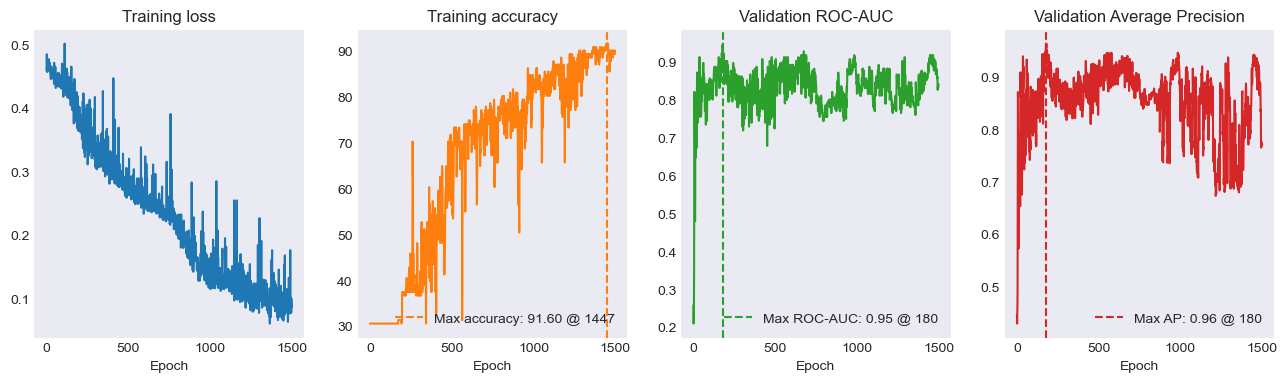

In [8]:
utils.plot_history(history)

## Validation on unseen data

Test ROC-AUC: 0.8722
Test AP: 0.9376


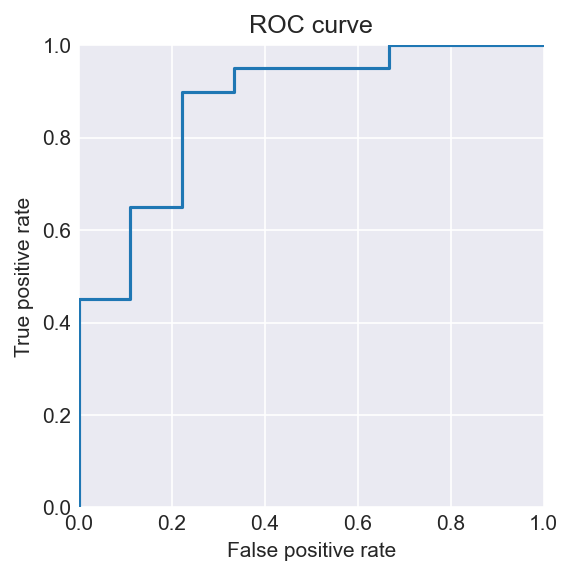

Number of correct positive predictions on test set: 14 out of 20
Number of correct negative predictions on test set: 7 out of 9


In [9]:
test_roc, test_ap, preds, ys = t.test(
    dataloaders[2].dataset, model, return_preds=True
)
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test AP: {test_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataloaders[2].dataset, model)
print(
    f"Number of correct positive predictions on test set: {torch.sum((preds > 0.5) & (ys == 1)).numpy()} out of {torch.sum(ys == 1).numpy()}"
)
print(
    f"Number of correct negative predictions on test set: {torch.sum((preds < 0.5) & (ys == 0)).numpy()} out of {torch.sum(ys == 0).numpy()}"
)

In [ ]:
utils.show_preds_distribution(preds, ys)

In [ ]:
utils.plot_confusion_matrix(preds, ys)

In [ ]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:20],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=4,
    n_rows=5,
    figsize=(8, 10),
)

## Full dataset performance

In [10]:
data_all = t.create_dataset_dict(add_edge_features=True)
full_dataset = t.MutagDataset(data_all)

### Full ROC curve

Full ROC-AUC: 0.9525
Full AP: 0.9631


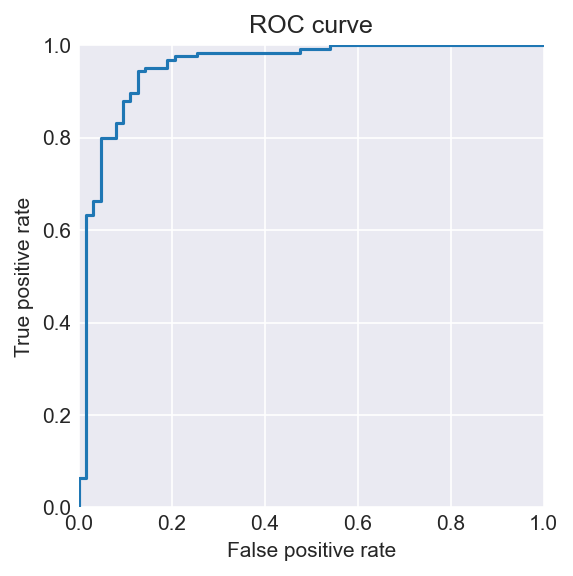

Number of correct positive predictions on test set: 107 out of 125
Number of correct negative predictions on test set: 57 out of 63


In [11]:
full_roc, full_ap, preds, ys = t.test(dataset, model, return_preds=True)
print(f"Full ROC-AUC: {full_roc:.4f}")
print(f"Full AP: {full_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataset, model)

preds = preds.cpu().detach().numpy()
ys = ys.cpu().detach().numpy()
print(
    f"Number of correct positive predictions on test set: {np.sum((preds > 0.5) & (ys == 1))} out of {np.sum(ys == 1)}"
)
print(
    f"Number of correct negative predictions on test set: {np.sum((preds < 0.5) & (ys == 0))} out of {np.sum(ys == 0)}"
)

### Predictions distribution

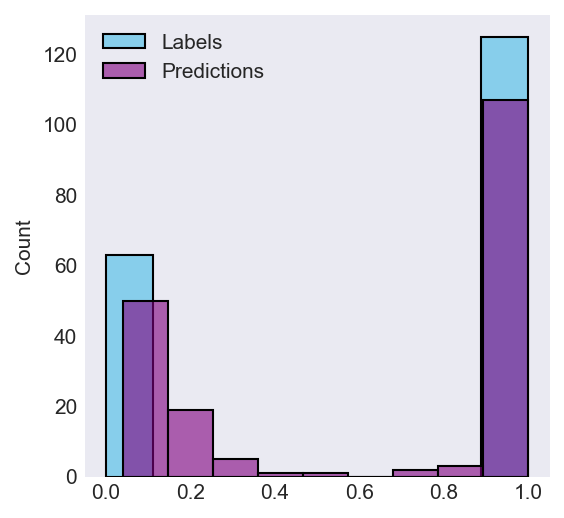

This plot shows the distribution of the labels and predictions; predictions are overlayed on top of the labels, showing whether they are missing or surnumerous.
The labels are 125 positive and 63 negative.
The predictions are 113 positive and 75 negative.


In [12]:
utils.show_preds_distribution(preds, ys)

### Confusion matrix

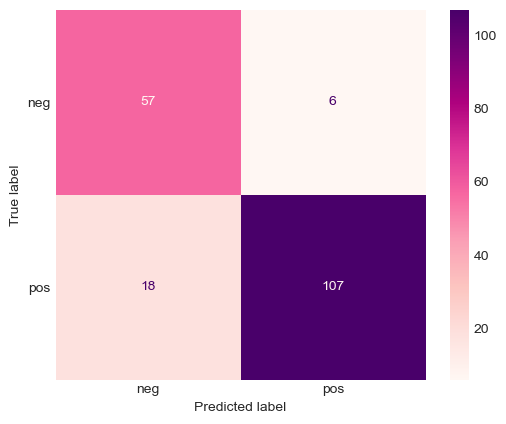

In [13]:
utils.plot_confusion_matrix(preds, ys)

### Check mislabelled molecules

24 mislabeled molecules


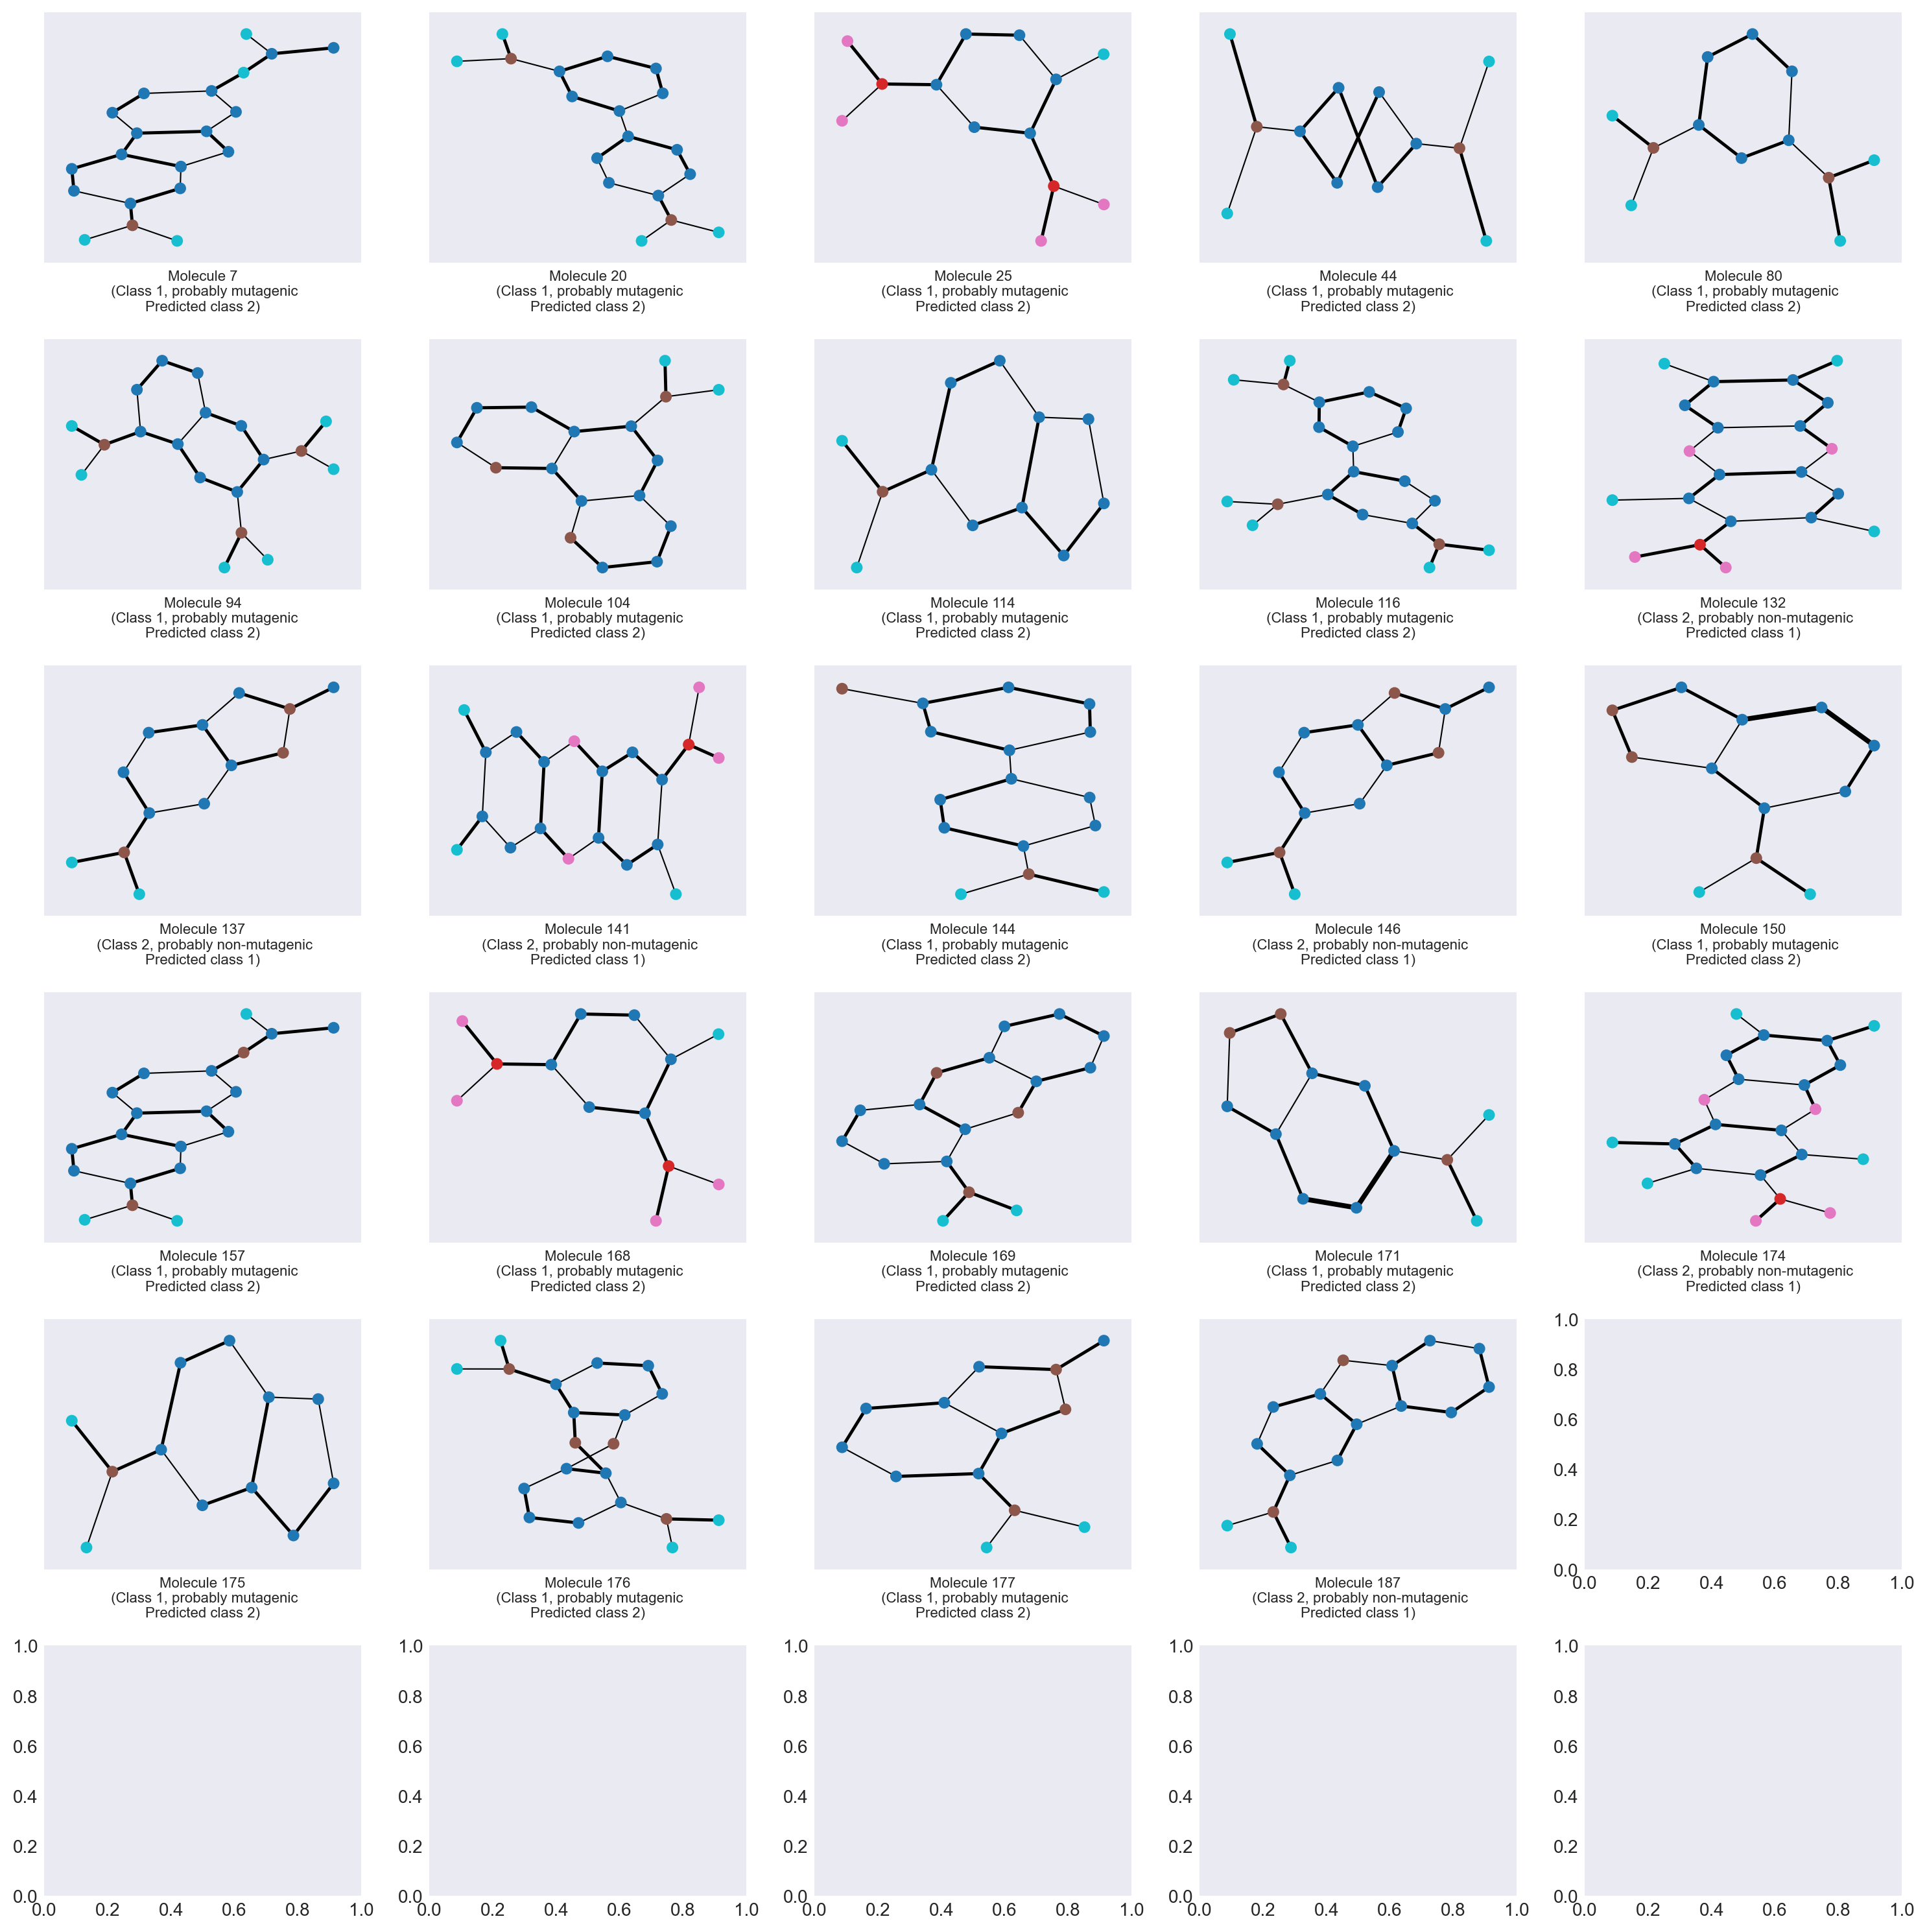

In [14]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:30],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=5,
    n_rows=6,
    figsize=(15, 15),
)